In [1]:
import pandas as pd
import numpy as np
import importlib
import os
from Utils import model_data_engineering
# from Utils import Models 
from Utils import preprocessing 
from Utils import plotting

# reload
importlib.reload(model_data_engineering)
importlib.reload(preprocessing)
importlib.reload(plotting)
# importlib.reload(Models)


# importing modules
from Utils.preprocessing import combine_csv_files
from Utils.preprocessing import perform_downsampling
from Utils.plotting import plot
from Utils.featureEngineering import creating_more_features
from Utils.model_data_engineering import create_Features_Scaling
from sklearn.model_selection import train_test_split


from Utils import Evaluation
importlib.reload(Evaluation)

from Utils.Evaluation import calculate_errors

from Utils import model_data_engineering
importlib.reload(model_data_engineering)
from Utils.model_data_engineering import create_Features_Scaling

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import os
from sklearn.model_selection import train_test_split
from darts.models.forecasting.xgboost import XGBModel 
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler


In [2]:
# # # Example usage
# df = combine_csv_files('../raw_data/', '../preprocessed_data/', saveFile=True)
# df.head()

In [3]:
# Example usage
df = pd.read_csv('../preprocessed_data/combined.csv')

In [4]:
hourly_df = perform_downsampling(df, freq='1H',aggregation_func='mean')


In [5]:
x_feature_name = 'Timestamp'
y_feature_name = 'Summe'
title = 'Hourly Plot '
plot(hourly_df,x_feature_name,y_feature_name,title = title,preview=True)

# XGB Model

In [17]:
series = TimeSeries.from_dataframe(hourly_df,'Timestamp','Summe',freq='1H')

train_series ,valid_series = TimeSeries.split_before(series,0.8)
train_series_input,valid_series_input = TimeSeries.split_before(train_series,0.2)
xgb_model =  XGBModel(lags=72,
                  lags_past_covariates=None,
                  lags_future_covariates = None,
                  output_chunk_length = 24,
                  add_encoders={
                                'cyclic': {'future': ['month']},
                                'datetime_attribute': {'future': ['hour', 'dayofweek']},
                                'position': {'past': ['relative'], 'future': ['relative']},
                                'custom': {'past': [lambda idx: (idx.year - 2014) / 50]},
                                'transformer': Scaler()
                            },
                  likelihood =  None , 
                  random_state = 1999,
                  quantiles= None,
                  multi_models = True,
                  use_static_covariates = False
              )

In [19]:
xgb_model.fit(train_series_input,val_series=valid_series_input)

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[0]	validation_0-rmse:111.27958
[1]	validation_0-rmse:105.02489
[2]	validation_0-rmse:103.22191
[3]	validation_0-rmse:102.10113
[4]	validation_0-rmse:101.93370
[5]	validation_0-rmse:102.32064
[6]	validation_0-rmse:102.83027
[7]	validation_0-rmse:103.25188
[8]	validation_0-rmse:103.80927
[9]	validation_0-rmse:103.75077
[10]	validation_0-rmse:103.93217
[11]	validation_0-rmse:104.16177
[12]	validation_0-rmse:104.37758
[13]	validation_0-rmse:104.54408
[14]	validation_0-rmse:104.71220
[15]	validation_0-rmse:104.77949
[16]	validation_0-rmse:105.04206
[17]	validation_0-rmse:105.30910
[18]	validation_0-rmse:105.39453
[19]	validation_0-rmse:105.47164
[20]	validation_0-rmse:105.55958
[21]	validation_0-rmse:105.71401
[22]	validation_0-rmse:105.84014
[23]	validation_0-rmse:105.95693
[24]	validation_0-rmse:106.03128
[25]	validation_0-rmse:106.06029
[26]	validation_0-rmse:106.17896
[27]	validation_0-rmse:106.23726
[28]	validation_0-rmse:106.23001
[29]	validation_0-rmse:106.29356
[30]	validation_0-rm

XGBModel(lags=72, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=24, add_encoders={'cyclic': {'future': ['month']}, 'datetime_attribute': {'future': ['hour', 'dayofweek']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function <lambda> at 0x7fd5c313e430>]}, 'transformer': Scaler}, likelihood=None, quantiles=None, random_state=1999, multi_models=True, use_static_covariates=False)

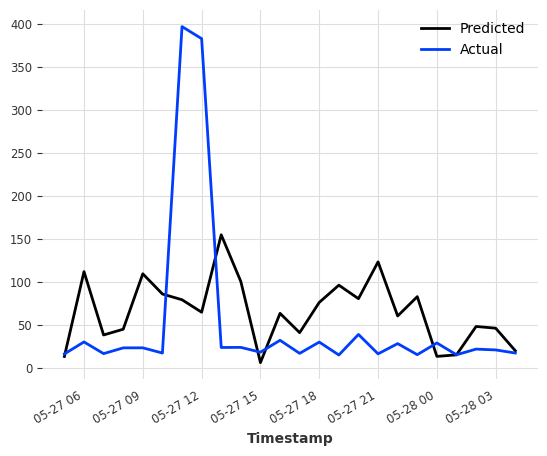

In [39]:
import matplotlib.pyplot as plt
xgb_model.predict(24).plot(label='Predicted')
valid_series_input[:24].plot(label='Actual')
plt.show()


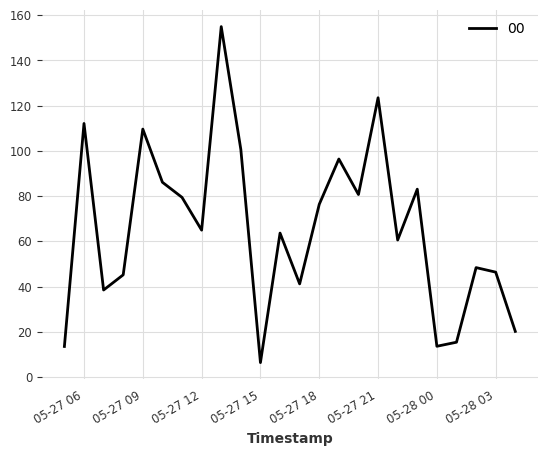

In [38]:
xgb_model.predict(24).plot(label='00')


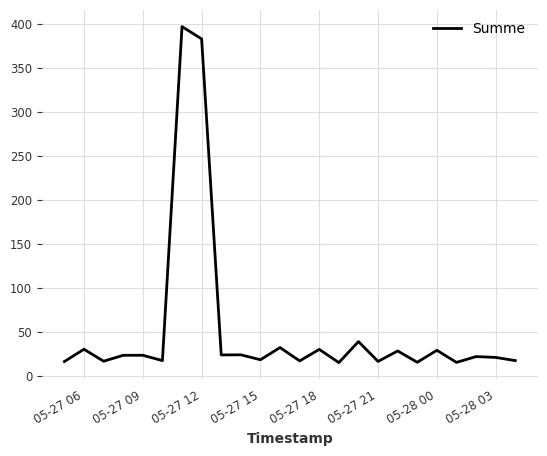

In [23]:
valid_series_input[:24].plot()

In [26]:
import matplotlib.pyplot as plt

# Assuming you have already imported your xgboost model and the required libraries

# Make predictions with the xgb_model on the first 24 elements of valid_series_input
predictions = xgb_model.predict(valid_series_input[:24])

# Plot the predictions with a label for the legend
plt.plot(predictions, label='Predicted Values')

# Plot the first 24 elements of valid_series_input with a label for the legend
plt.plot(valid_series_input[:24], label='Actual Values')

# Set the title of the plot
plt.title('XGBoost Model Predictions vs. Actual Values')

# Add a legend to the plot with titles
plt.legend(title='Legend')

# Show the plot
plt.show()


TypeError: 'TimeSeries' object cannot be interpreted as an integer